In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

%matplotlib inline


'''Import data files'''

# Anime title, user ratings, and genres
anime_list = pd.read_csv('/Users/nickburkhalter/Desktop/Data Science/Projects/Data Sets/Anime/anime-recommendations-database/anime.csv')



print(anime_list.shape)
print('-----------------------------------------')
print(anime_list.columns)
print('-----------------------------------------')
print(anime_list.isnull().sum())
print('-----------------------------------------')
print(anime_list.describe())

(12294, 7)
-----------------------------------------
Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')
-----------------------------------------
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
-----------------------------------------
           anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+03
75%    24794.500000      7.180000  9.437000e+03
max    34527.000000     10.000000  1.013917e+06


In [2]:
'''Analysis of the anime_list DataFrame'''

# Count the null values in each column of the dataset
print(anime_list.isnull().sum())

'''We see that there are 62 elements in the genre column without entries. Because the dataset contains 12294 anime,
and we are only interested in the top 50 Shounen anime, we can safely assume these 62 unclassified anime can be
dropped without adversely affecting our research'''

anime_list = anime_list.dropna(subset=['genre','type','rating'])

# View the shape of the dataset
print(anime_list.shape)

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
(12017, 7)


In [3]:
'''We will further clean the data by excluding the columns that are of no interest to our objective'''

anime_list = anime_list[['name', 'genre', 'type', 'rating', 'members']]

anime_list

,name,genre,type,rating,members
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.37,200630
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.26,793665
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.25,114262
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.17,673572
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.16,151266
5,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,9.15,93351
6,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,9.13,425855
7,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,9.11,80679
8,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,9.10,72534
9,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.11,81109


In [4]:
'''From an initial check of the data, we can see that both the rating and members columns play significant roles in
determining the popularity of an anime. We will assign a weighted score to each anime based on their overall ranking
and their overall member numbers over the next few cells. 

The first step will be to remove any anime with less than 200000 members (because we want *popular* anime). Next, we 
will sort the data so that the anime with the most followers will be represented first since the data originally 
had the anime sorted by rank.'''

# Filter DataFrame to show only anime with "Shounen" listed as a genre
anime_list = anime_list[anime_list['genre'].str.contains('Shounen')]

# Show only anime that have 200000 or more members
anime_list = anime_list[anime_list['members'] > 199999]

# Sort anime by member number in descending order
anime_list = anime_list.sort_values('members', ascending=False)

anime_list

,name,genre,type,rating,members
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,8.54,896229
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.26,793665
841,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,7.81,683297
445,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,8.07,657190
582,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,7.95,624055
200,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,8.33,600384
288,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",TV,8.22,584590
643,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,7.92,583823
440,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,8.08,580184
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,7.94,533578


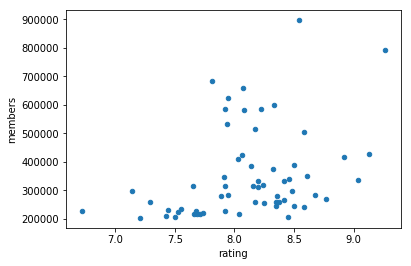

In [5]:
'''Next, we want to see how strong the relationship is between rank and members, and if there is anything worth 
pursuing here. We will perform a simple correlation test at first and see if we can deduce the relationship that way. 
Basically, what we are looking for is evidence that either rank or members is more heavily weighted in determining the 
popularity of an anime.'''

# Perform Pearson's correlation on DataFrame
anime_list.corr(method='pearson')                # 0.339851 correlation between rating and members

# Visualize the correlation via scatterplot
anime_list.plot.scatter(x='rating', y='members')

In [6]:
'''The linear correlation between a series rating and members does not suggest that more weight be applied to
*either* column when determining the overall popularity of an anime. Therefore, equal weight will be applied to both 
in order to conduct our weighted-score for each show. This weighted score will be used to help us determine the true
popularity of the anime.

We will compute a weighted score based on a 0-100 scale, where 50% of the score is allocated to rating, and 50% 
allocated to members. The general layout of the formula is as follows:

0.50(rating * 10) + 0.50(members/10000)

'''

# Create function to calculate weighted score
def weighted_score(i, j):
    
    return ((0.50 * (i *10)) + (0.50 * (j / 10000)))

# Create score column and map the weighted_score function to it
anime_list['score'] = list(map(weighted_score, anime_list['rating'], anime_list['members']))

# Sort data in descending order by score
anime_list = anime_list.sort_values('score', ascending=False)

anime_list

,name,genre,type,rating,members,score
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,8.54,896229,87.51145
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.26,793665,85.98325
841,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,7.81,683297,73.21485
445,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,8.07,657190,73.20950
200,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,8.33,600384,71.66920
582,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,7.95,624055,70.95275
288,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",TV,8.22,584590,70.32950
440,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,8.08,580184,69.40920
643,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,7.92,583823,68.79115
74,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,8.58,504862,68.14310


In [7]:
'''We can see that in some instances there are different mentions of the same franchise. We will need to 
further edit the data so that we get the top 50 *unique* shows. To do this, we will utilize COSINE SIMILARITY to find
similar elements, then remove the similar elements based on a specified threshold. The trick here is to make sure the
*first* instance of the anime title remains in tact (if it gets deleted, it may inadvertently remove a top 50 anime 
from our list)'''

# Use sklearn to find cosine similarity between anime names
tfidf = TfidfVectorizer().fit_transform(anime_list['name'])    # Convert strings in column 'name' to Tf-idf vectors
similarity = cosine_similarity(tfidf)                          # Calculate cosine similarity between all rows in df


# Turn cosine similarity matrix into Pandas DataFrame
similarity_df = pd.DataFrame(similarity)

# Pull anime names from anime_list
anime_names = anime_list['name'].tolist()

# Add names to our similarity_df for easier reference
similarity_df = similarity_df.assign(name=anime_names)

# Filter DataFrame to only show rows/columns where similarities exceed threshold (i < 1 and i > 0.65)
similarity_df = similarity_df[similarity_df > 0.65]
similarity_df = similarity_df.replace(np.nan, 0, regex=True) # replace NaN to make data easier to manipulate
    
    

similarity_df

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,name
0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Shingeki no Kyojin
1,0.0,1.000000,0.000000,0.0,0.789162,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fullmetal Alchemist: Brotherhood
2,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Naruto
3,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Mirai Nikki (TV)
4,0.0,0.789162,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fullmetal Alchemist
5,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Bleach
6,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fairy Tail
7,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Soul Eater
8,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Ao no Exorcist
9,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,One Piece


In [8]:
'''Now that we have the duplicate franchises identified, we will do the last bit of manipulation on the dataset to 
remove the culprits and identify the top 50 *unique* anime titles.

In the above cell, we computed the cosine similarity of each title against all other titles to create a new DataFrame. 
Frome there, we analyzed the initial output and determined the threshold for duplicates to be around 0.65. We then 
filtered the new DataFrame to show only those values that were above the threshold. Finally, we replaced the NaN values 
that resulted from our filter with 0 in order to perform mathematical operations on the rows.

Here, we will create a new column in our DataFrame called 'totals' that sums the values of each column in the row. 
For values that are greater than 1, it means we have a similar title somewhere in our dataset. If the sums are 
identical, it means we have a match. We will then drop the duplicates to finish our list of the top 50 unique anime
titles.

'''

# Add new column that calculates row totals
similarity_df['totals'] = similarity_df.sum()

similarity_df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,name,totals
0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Shingeki no Kyojin,1
1,0.0,1.000000,0.000000,0.0,0.789162,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fullmetal Alchemist: Brotherhood,1.78916
2,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Naruto,1.67246
3,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Mirai Nikki (TV),1
4,0.0,0.789162,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fullmetal Alchemist,1.78916
5,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Bleach,1
6,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fairy Tail,1.78916
7,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Soul Eater,1
8,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Ao no Exorcist,1
9,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,One Piece,1


In [24]:
'''From the aove table, it seems that the totals column has created quite a few identical values. Thankfully, the 
remaining dataset is small enough to eyeball, so we will manually drop the duplicate franchise names from here.

Had each result greater than 1 had only 2 instances, we could have dropped the duplicate rows, since there would be 
only 1 duplicate for each. But that is not the case, here. Given the end goal of this project, further programmed 
cleaning would be wasted energy, so we will just brute force the remainder of this list creation'''

similarity_df['totals'].value_counts()        # 40 instances of 1.00000
                                              # 6 instances of 1.672456
                                              # 4 instances of 1.789162
                                              # 2 instances of 1.761234
                                              # 2 instances of 2.766411
                                              # 2 instances of 1.758865
                                              # 2 instances of 1.732787
                                              # 2 instances of 1.881331
                                              # 1 instance of 2.532822
                                
                                
similarity_df = similarity_df.drop(similarity_df.index[[4, 12, 25, 30, 34, 36, 40, 44, 50, 54, 60]])

similarity_df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,name,totals
0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Shingeki no Kyojin,1
1,0.0,1.0,0.0,0.0,0.789162,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fullmetal Alchemist: Brotherhood,1.78916
2,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Naruto,1.67246
3,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Mirai Nikki (TV),1
5,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Bleach,1
6,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Fairy Tail,1.78916
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Soul Eater,1
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Ao no Exorcist,1
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,One Piece,1
10,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,Hunter x Hunter (2011),1


In [9]:
'''Last but not least, we will extract the remaining names from the DataFrame and convert them to a Series for 
readability.

Ladies and gentlemen, I present to you the TOP 50 UNIQUE ANIME TITLES!

'''

names = similarity_df['name'].tolist()

top_anime = pd.Series(names)

top_anime

0                                    Shingeki no Kyojin
1                      Fullmetal Alchemist: Brotherhood
2                                                Naruto
3                                      Mirai Nikki (TV)
4                                   Fullmetal Alchemist
5                                                Bleach
6                                            Fairy Tail
7                                            Soul Eater
8                                        Ao no Exorcist
9                                             One Piece
10                               Hunter x Hunter (2011)
11                                             Noragami
12                                   Naruto: Shippuuden
13                              Shigatsu wa Kimi no Uso
14                                              Gintama
15                                     Samurai Champloo
16                                         Kuroshitsuji
17                                  Hataraku Mao